<a href="https://colab.research.google.com/github/yashc73080/CS462-Deep-Learning/blob/main/HW2/features_unsupervised_and_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm.auto import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 1. Auto-Encoders

Get MNIST dataloaders

In [3]:
mnist_tfm = transforms.Compose([transforms.ToTensor()])
mnist_train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=mnist_tfm)
mnist_test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=mnist_tfm)

mnist_train_loader = DataLoader(mnist_train_ds, batch_size=128, shuffle=True, num_workers=2)
mnist_test_loader = DataLoader(mnist_test_ds, batch_size=256, shuffle=False, num_workers=2)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


Create Auto-Encoder classes and functions

In [19]:
class Encoder(nn.Module):
  def __init__(self, input_size=784, enc_hidden=500, bottleneck_k=200, device='cpu'):
    '''
    Encoder module with architecture: Input (784) -> Hidden -> Bottleneck k
    '''
    super().__init__()

    layers = []
    layers.append(nn.Linear(input_size, enc_hidden))
    layers.append(nn.ReLU())
    layers.append(nn.Linear(enc_hidden, bottleneck_k))

    self.encoder = nn.Sequential(*layers)

  def forward(self, x):
    return self.encoder(x)


class Decoder(nn.Module):
  def __init__(self, bottleneck_k=200, dec_hidden=500, output_size=784, device='cpu'):
    '''
    Decoder module with architecture: Bottleneck k -> Hidden -> Output (784)
    '''
    super().__init__()

    layers = []
    layers.append(nn.Linear(bottleneck_k, dec_hidden))
    layers.append(nn.ReLU())
    layers.append(nn.Linear(dec_hidden, output_size))

    self.decoder = nn.Sequential(*layers)

  def forward(self, x):
    return self.decoder(x)


class AutoEncoder(nn.Module):
  def __init__(self, in_out_size=784, enc_hidden=500, dec_hidden=500, bottleneck_k=200, device='cpu'):
    '''
    AutoEncoder module with architecture: Input (784) -> Hidden -> Bottleneck k -> Hidden -> Output (784)
    '''
    super().__init__()
    self.encoder = Encoder(input_size=in_out_size, enc_hidden=enc_hidden, bottleneck_k=bottleneck_k, device=device)
    self.decoder = Decoder(bottleneck_k=bottleneck_k, dec_hidden=dec_hidden, output_size=in_out_size, device=device)

    self.to(device)

  def forward(self, x):
    return self.decoder(self.encoder(x))


def train_autoencoder(model, train_loader, optimizer, reconstruction_loss):
  model.train()
  total_loss = 0.0

  for images, _ in train_loader:
    images = images.view(images.size(0), -1).to(device)

    optimizer.zero_grad()
    reconstructed = model(images)
    loss = reconstruction_loss(reconstructed, images)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)

  return avg_loss

def test_autoencoder(model, test_loader, reconstruction_loss):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images.view(images.size(0), -1).to(device)
      reconstructed_images = model(images)
      loss = reconstruction_loss(reconstructed_images, images)
      total_loss += loss.item()

  avg_test_loss = total_loss / len(test_loader)

  return avg_test_loss

def train_test_autoencoder(model, train_loader, test_loader, epochs=5, lr=0.001, plot=False, curr_k=None, device='cpu'):
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=lr)
  reconstruction_loss = nn.MSELoss()

  train_losses = []
  test_losses = []

  tqdm_desc = f"k={curr_k} - Epoch" if curr_k is not None else "Epoch"

  for epoch in tqdm(range(epochs), desc=tqdm_desc):
    train_loss = train_autoencoder(model, train_loader, optimizer, reconstruction_loss)
    test_loss = test_autoencoder(model, test_loader, reconstruction_loss)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

  if plot:
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Loss')
    plt.show()

  return train_losses, test_losses

def visualize_reconstructions(model, test_loader, num_images=5):
  model.eval()
  with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images[:num_images].view(num_images, -1).to(device)
    reconstructed = model(images).cpu().view(-1, 1, 28, 28)

    fig, axes = plt.subplots(2, num_images, figsize=(num_images*1.5, 3))
    for i in range(num_images):
      axes[0, i].imshow(images[i].cpu().view(28, 28), cmap='gray')
      axes[0, i].axis('off')
      axes[1, i].imshow(reconstructed[i].view(28, 28), cmap='gray')
      axes[1, i].axis('off')

    plt.suptitle("Originals (top) vs Reconstructions (bottom)")
    plt.show()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

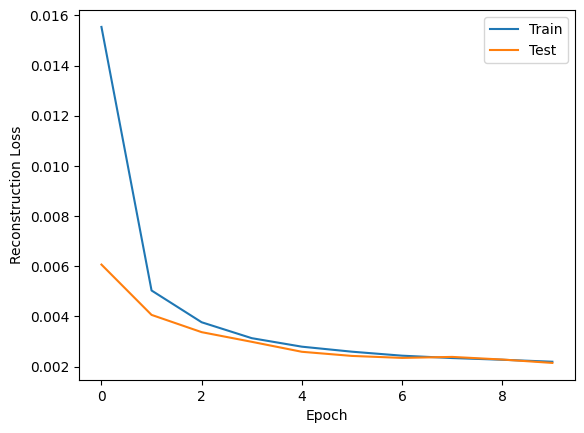

Final Train Loss: 0.0021956156232336693
Final Test Loss: 0.0021477524598594753


In [21]:
autoencoder = AutoEncoder(in_out_size=784, enc_hidden=1000, dec_hidden=1000, bottleneck_k=200, device=device)
train_losses, test_losses = train_test_autoencoder(autoencoder, mnist_train_loader, mnist_test_loader, epochs=10, lr=0.001, plot=True, device=device)

print(f'Final Train Loss: {train_losses[-1]}')
print(f'Final Test Loss: {test_losses[-1]}')

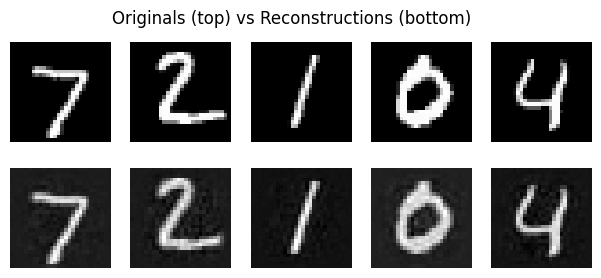

In [13]:
visualize_reconstructions(autoencoder, mnist_test_loader)

Find best k

k=1 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=2 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=3 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=5 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=10 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=20 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=50 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=100 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=200 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=300 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=500 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=700 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

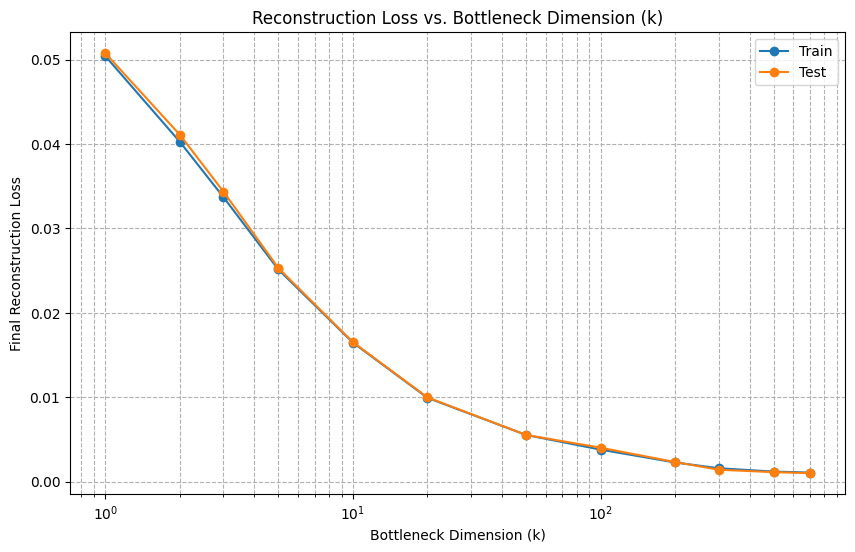

Best k: 700


In [23]:
possible_k = [1, 2, 3, 5, 10, 20, 50, 100, 200, 300, 500, 700]

train_losses = []
test_losses = []
for k in possible_k:
  autoencoder_k = AutoEncoder(in_out_size=784, enc_hidden=1000, dec_hidden=1000, bottleneck_k=k, device=device)
  train_losses_k, test_losses_k = train_test_autoencoder(autoencoder_k, mnist_train_loader, mnist_test_loader, epochs=10, lr=0.001, plot=False, curr_k=k, device=device)

  train_losses.append(train_losses_k[-1])
  test_losses.append(test_losses_k[-1])

plt.figure(figsize=(10, 6))
plt.plot(possible_k, train_losses, label='Train', marker='o')
plt.plot(possible_k, test_losses, label='Test', marker='o')
plt.legend()
plt.xlabel('Bottleneck Dimension (k)')
plt.ylabel('Final Reconstruction Loss')
plt.xscale('log')
plt.title('Reconstruction Loss vs. Bottleneck Dimension (k)')
plt.grid(True, which="both", ls="--")
plt.show()

# Best k based on loss
print(f'Best k: {possible_k[np.argmin(test_losses)]}')

k=1 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=3 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=5 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=10 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=20 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=50 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=70 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=100 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=200 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=300 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=500 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=700 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

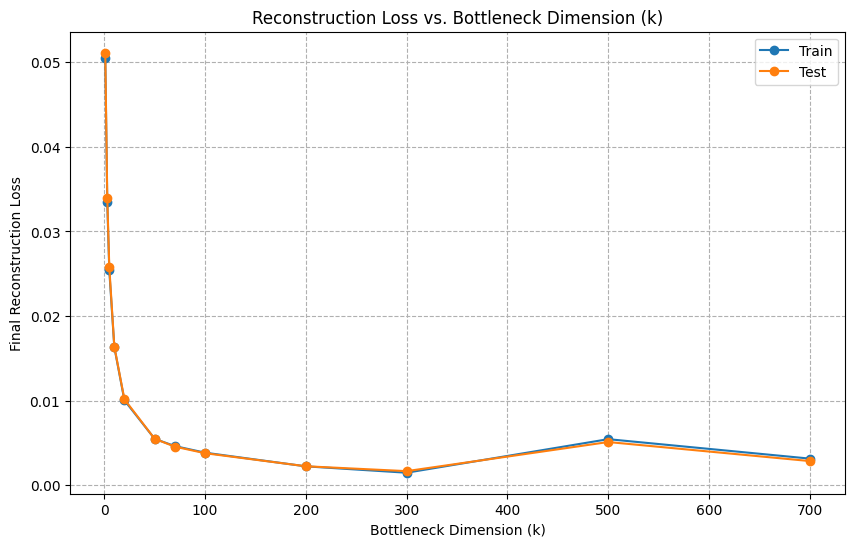

Best k: 300


In [24]:
possible_k = [1, 3, 5, 10, 20, 50, 70, 100, 200, 300, 500, 700]

train_losses = []
test_losses = []
for k in possible_k:
  autoencoder_k = AutoEncoder(in_out_size=784, enc_hidden=1000, dec_hidden=1000, bottleneck_k=k, device=device)
  train_losses_k, test_losses_k = train_test_autoencoder(autoencoder_k, mnist_train_loader, mnist_test_loader, epochs=10, lr=0.001, plot=False, curr_k=k, device=device)

  train_losses.append(train_losses_k[-1])
  test_losses.append(test_losses_k[-1])

plt.figure(figsize=(10, 6))
plt.plot(possible_k, train_losses, label='Train', marker='o')
plt.plot(possible_k, test_losses, label='Test', marker='o')
plt.legend()
plt.xlabel('Bottleneck Dimension (k)')
plt.ylabel('Final Reconstruction Loss')
plt.title('Reconstruction Loss vs. Bottleneck Dimension (k)')
plt.grid(True, which="both", ls="--")
plt.show()

# Best k based on loss
print(f'Best k: {possible_k[np.argmin(test_losses)]}')